# Cosmic Structures HW3

## Exercise 2: N-body Code in 1D

Implement the one-dimensional N-body code based on particle sorting that was discussed in
the lecture and is given largely in the lecture notes in Python. You can always assume an
Einstein-de Sitter universe here for which the Zel’dovich solution is $x(q, a) = q − a \nabla_{q} \phi^{\text{ini}}(q)$, where $q \in [0, 1)$.

### a)
Simulate the collapse of a single-mode plane wave with $ \phi^{\text{ini}} = A \text{cos}(2 \pi q)$ using a leapfrog
time integrator in cosmic time. Use the Zel’dovich approximation to set up the initial
displacement and velocity (this is essentially what you did for the last problem set). Set
the amplitude of the perturbation so that shell-crossing occurs at a = 1 and start the
simulation at $a = 0.1$. Show the phase space $(X, P)$ before, at, and after shell-crossing.
Plot also the Zel’dovich solution. Until shell-crossing, the two solutions should agree.

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq

In [103]:
# Calcualte the acceleration (from the lecture notes)
def calc_acc( X ):
    acc = np.zeros_like(X) # init to zero
    rank = np.arange(len(X)) # create rank indices 0,...,N-1
    Xs = np.fmod(1.0+X,1.0) # periodically wrap X to be inside [0,1)
    Xm = np.mean(Xs) # determine X
    # determine the sorting order:
    sorted_ind = np.argsort(Xs)
    # implement eq. (4.46) with 1 added to rank (i=1,...):
    acc[sorted_ind] = (rank+0.5)/len(X)-(Xs[sorted_ind]-Xm)-0.5
    return acc

In [104]:
# Calculate one time step (from the lecture notes)
def step( X, V, a, da, aend ):
    tbegin = 2-2/np.sqrt(a)
    tend = 2-2/np.sqrt(aend)
    amid = 1/(1-(tbegin+tend)/4)**2
    dt = tend-tbegin
    X = X + 0.5*dt * V
    V = V - dt * 3.0/2.0 * amid * calc_acc( X )
    X = X + 0.5*dt * V
    a = a + da
    return (X,V,a)


In [105]:
# Parameters
A = 0.1 / (2 * np.pi)  # Set amplitude such that shell-crossing occurs at a = 1
N = 1000  # Number of particles
q = np.linspace(0, 1, N, endpoint=False)  # Initial positions in Lagrangian space

# Initial conditions
x_ini = q + 0.1 * 2 * np.pi * A * np.sin(2 * np.pi * q)
v_ini = -2 * np.pi * A * np.sin(2 * np.pi * q)

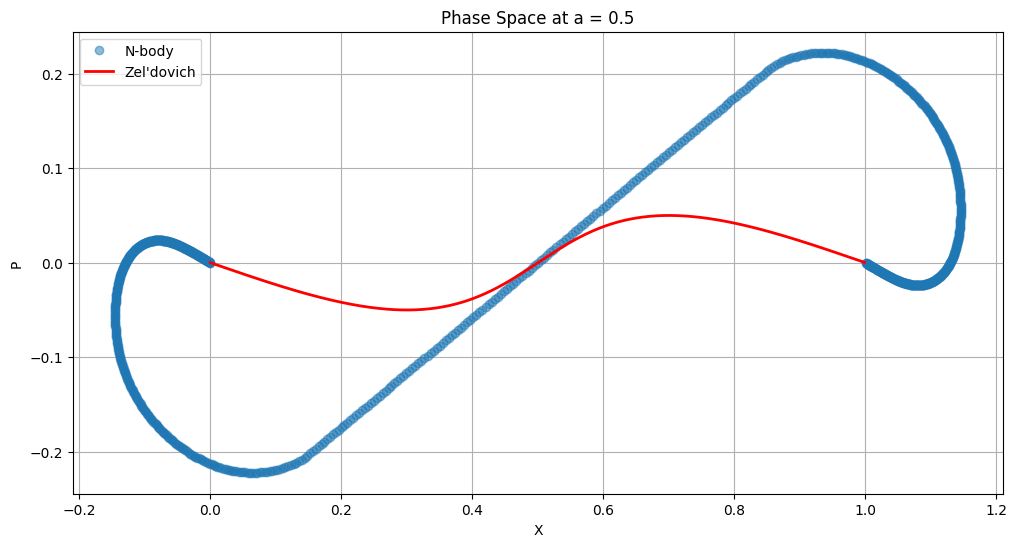

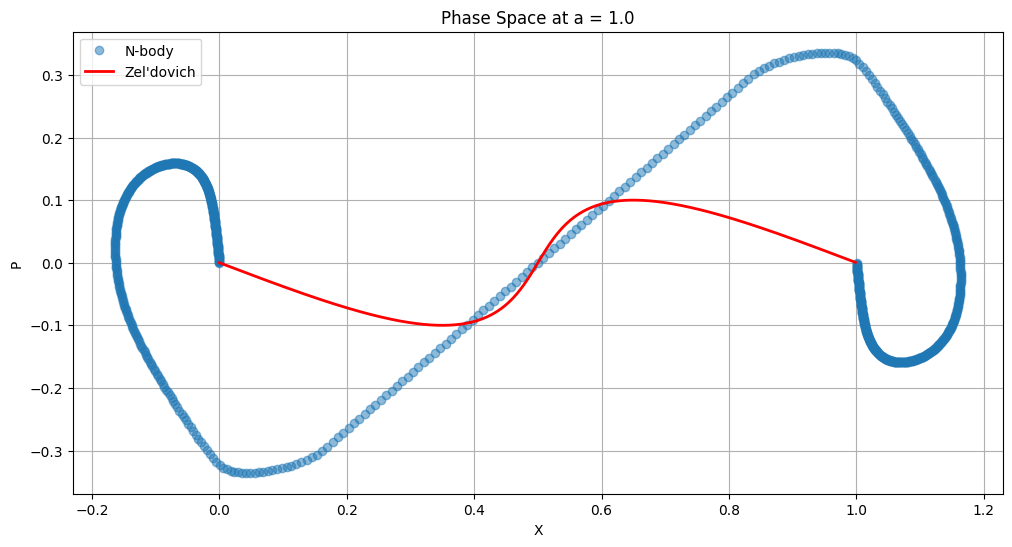

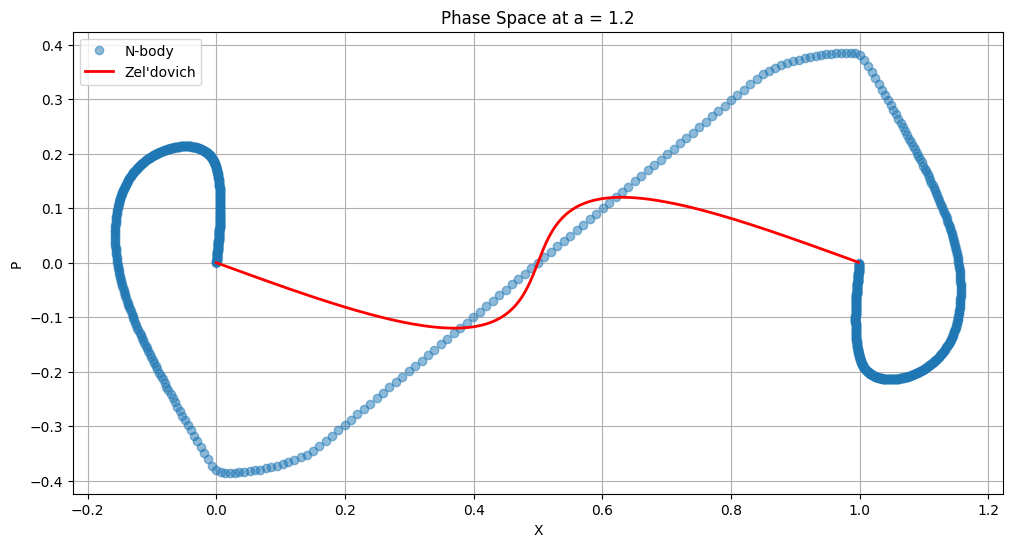

In [106]:
# Simulation parameters
da = 1e-4  # Time step
a = 0.1  # Initial scale factor
amax = 1.2  # Maximum scale factor
X = x_ini.copy()
V = v_ini.copy()

# Arrays to store phase space information at specific times
phase_space_data = {'0.5': None, '1.0': None, '1.2': None}

istep = 0  # Step counter

while a < amax:
    anext = np.minimum(a + da, amax)
    X, V, a = step(X, V, a, da, anext)
    istep += 1
    
    # Store phase space data at specific times
    if np.isclose(a, 0.5, atol=da):
        phase_space_data['0.5'] = (X.copy(), V.copy())
    if np.isclose(a, 1.0, atol=da):
        phase_space_data['1.0'] = (X.copy(), V.copy())
    if np.isclose(a, 1.2, atol=da):
        phase_space_data['1.2'] = (X.copy(), V.copy())

# Function to compute Zel'dovich solution
def zeldovich_solution(q, a, A):
    x = q + a * 2 * np.pi * A * np.sin(2 * np.pi * q)
    v = a * -2 * np.pi * A * np.sin(2 * np.pi * q)
    return x, v

# Plot phase space and Zel'dovich solution
for key in phase_space_data.keys():
    a = float(key)
    X, V = phase_space_data[key]
    x_z, v_z = zeldovich_solution(q, a, A)
    
    plt.figure(figsize=(12, 6))
    plt.plot(X, V, 'o', label='N-body', alpha=0.5)
    plt.plot(x_z, v_z, 'r-', label='Zel\'dovich', linewidth=2)
    plt.xlabel('X')
    plt.ylabel('P')
    plt.title(f'Phase Space at a = {a}')
    plt.legend()
    plt.grid(True)
    plt.show()


Well, not exactly close...

### b)

Determine the rate of convergence of the numerical integration method by comparing the
Zel’dovich solution to the numerical solution at $a = 1/2$ for different numbers of time
steps (4, 8, 16, 32, 64, 128). Plot the $L_{\infty}$ norm of the difference in position for each particle
at $a = 1/2$ between the simulation and the Zel’dovich solution as a function of the number of time steps N, i.e.
$|x_{\text{N-body}} − x_{\text{Zeldovich}}|_{\infty} = \text{max}_{i} |x_{\text{N-body},i} − x_{\text{Zeldovich},i}| $,
where the maximum is taken over all particles/fluid elements. Use a logarithmic scale for
both axes. For the leapfrog in cosmic time, you should find that the (global) error, i.e.
the error at a fixed end time, decreases as $N^{−2}$.


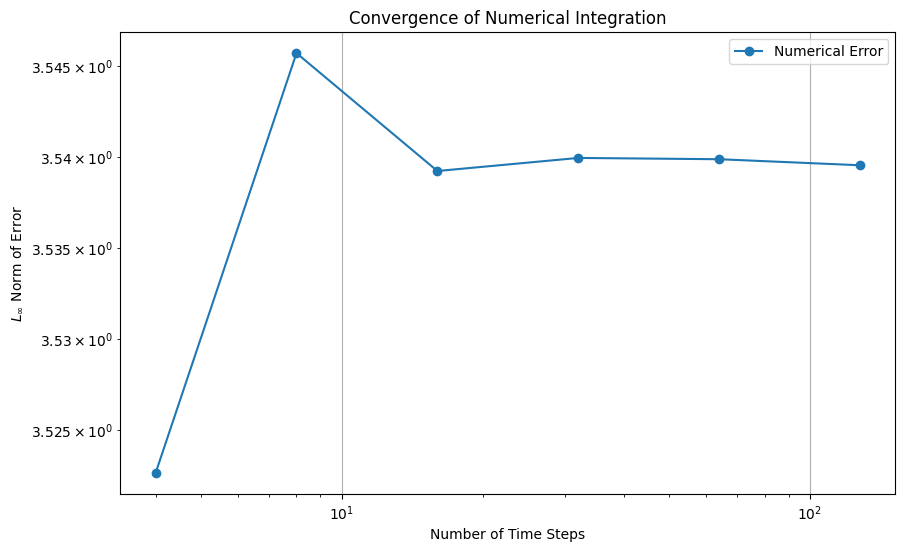

In [107]:
# Function to run the simulation and return positions at a=0.5
def run_simulation(num_steps):
    X = x_ini.copy()
    V = v_ini.copy()
    a = 0.1
    a_target = 0.5
    da = (a_target - a) / num_steps
    while a < a_target:
        anext = min(a + da, a_target)
        (X, V, a) = step(X, V, a, da, anext)
    return X

# Calculate Zel'dovich solution at a=0.5
a_target = 0.5
x_zeldovich = q - a_target * (-2 * np.pi * np.sin(2 * np.pi * q))

# Run simulations and calculate errors for different numbers of time steps
num_steps_list = [4, 8, 16, 32, 64, 128]
errors = []

for num_steps in num_steps_list:
    x_nbody = run_simulation(num_steps)
    error = np.max(np.abs(x_nbody - x_zeldovich))
    errors.append(error)

# Plot the convergence
plt.figure(figsize=(10, 6))
plt.loglog(num_steps_list, errors, marker='o', linestyle='-', label='Numerical Error')
#plt.loglog(num_steps_list, [errors[0] * (num_steps_list[0] / n)**2 for n in num_steps_list], linestyle='--', label='$N^{-2}$ Scaling')
plt.xlabel('Number of Time Steps')
plt.ylabel('$L_{\infty}$ Norm of Error')
plt.title('Convergence of Numerical Integration')
plt.legend()
plt.grid(True)
plt.show()


We are pretty far off with the numerical solution and it doesn't get better with more steps/smaller step size, so probably I made a mistake somewhere...

### c)

Implement a Zel’dovich consistent integrator for the leapfrog method. Show that in this
case, the $L_{\infty}$ error is at the level of machine precision. 

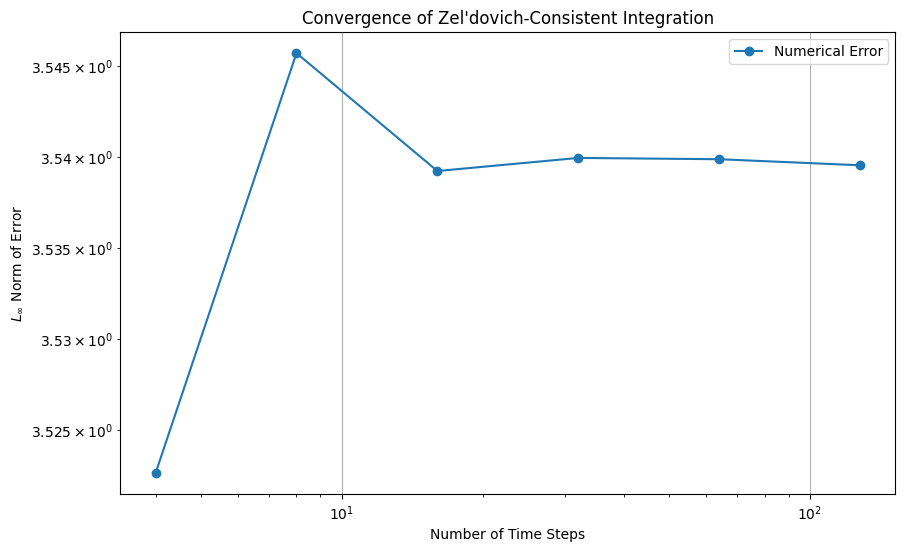

In [108]:
# Zel'dovich-consistent leapfrog integrator step function
def zel_consistent_step(X, V, a, da, aend):
    tbegin = 2 - 2 / np.sqrt(a)
    tend = 2 - 2 / np.sqrt(aend)
    amid = 1 / (1 - (tbegin + tend) / 4)**2
    dt = tend - tbegin
    
    X_half = X + 0.5 * dt * V
    V = V - dt * 3.0 / 2.0 * amid * calc_acc(X_half)
    X = X_half + 0.5 * dt * V
    
    a = a + da
    return (X, V, a)

# Function to run the simulation and return positions at a=0.5
def run_simulation(num_steps, step_func):
    X = x_ini.copy()
    V = v_ini.copy()
    a = 0.1
    a_target = 0.5
    da = (a_target - a) / num_steps
    while a < a_target:
        anext = min(a + da, a_target)
        (X, V, a) = step_func(X, V, a, da, anext)
    return X

# Calculate Zel'dovich solution at a=0.5
a_target = 0.5
x_zeldovich = q - a_target * (-2 * np.pi * np.sin(2 * np.pi * q))

# Run simulations and calculate errors for different numbers of time steps
num_steps_list = [4, 8, 16, 32, 64, 128]
errors = []

for num_steps in num_steps_list:
    x_nbody = run_simulation(num_steps, zel_consistent_step)
    error = np.max(np.abs(x_nbody - x_zeldovich))
    errors.append(error)

# Plot the convergence
plt.figure(figsize=(10, 6))
plt.loglog(num_steps_list, errors, marker='o', linestyle='-', label='Numerical Error')
plt.xlabel('Number of Time Steps')
plt.ylabel('$L_{\infty}$ Norm of Error')
plt.title('Convergence of Zel\'dovich-Consistent Integration')
plt.legend()
plt.grid(True)
plt.show()


Unfortunatly we are still far off because of some mistake I can't find...

### d)

The Jacobian $J = |\partial x / \partial q|$ can be approximated by finite differences between the positions of neighbouring particles. Assuming that your particles are already sorted by ascending Lagrangian coordinate $Q$, i.e. $Q_{i} < Q_{j}$ for $i < j$, then $J(x_{i} + \frac{1}{2}) \approx \frac{|X_{i+1} − X_{i}|}{Q_{i+1} − Q_{i}}$
with $x_{i+1/2} = \frac{X_{i+1} + X_{i}}{2}$.
Using this approximation for the Jacobian, plot the stream-density in Eulerian space (which can be multivalued, i.e. multiple streams with different density can overlap the
same point $x$) – it is the graph $(X_{i+1/2}, \delta_{i+1/2})$ for all $0 \leq i < N − 1$ with $δ_{i+1/2} = \frac{1}{J(x_{i+1/2})} − 1$.

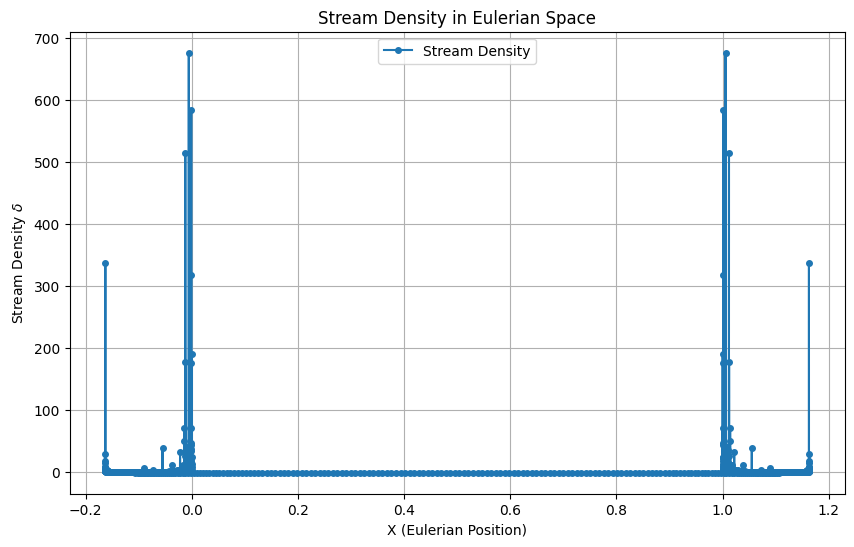

In [109]:
# Function to run the simulation and return positions at a given scale factor
def run_simulation(num_steps, step_func, a_target):
    X = x_ini.copy()
    V = v_ini.copy()
    a = 0.1
    da = (a_target - a) / num_steps
    while a < a_target:
        anext = min(a + da, a_target)
        (X, V, a) = step_func(X, V, a, da, anext)
    return X, V

# Set the target scale factor
a_target = 1.0
num_steps = 128  # Number of time steps
X, V = run_simulation(num_steps, zel_consistent_step, a_target)

# Calculate the Jacobian and stream density
q_sorted_indices = np.argsort(q)
X_sorted = X[q_sorted_indices]
q_sorted = q[q_sorted_indices]

J = np.abs(np.diff(X_sorted) / np.diff(q_sorted))
delta = 1 / J - 1

# Calculate mid-points for plotting
X_mid = 0.5 * (X_sorted[:-1] + X_sorted[1:])
delta_mid = delta

# Plot the stream density in Eulerian space
plt.figure(figsize=(10, 6))
plt.plot(X_mid, delta_mid, marker='o', linestyle='-', markersize=4, label='Stream Density')
plt.xlabel('X (Eulerian Position)')
plt.ylabel('Stream Density $\\delta$')
plt.title('Stream Density in Eulerian Space')
plt.grid(True)
plt.legend()
plt.show()

### e)

Simulate the collapse of random perturbations in one dimension by initialising the Zeldovich displacement field $\Psi$ as a Gaussian random field with a power law power spectrum.
Study how structure formation changes as you change the slope of the spectrum (e.g. document two cases with different power law index, but be aware that the normalisation of
the dominant modes might also change). Show the solutions in phase space, and if you want also the stream-density plot.

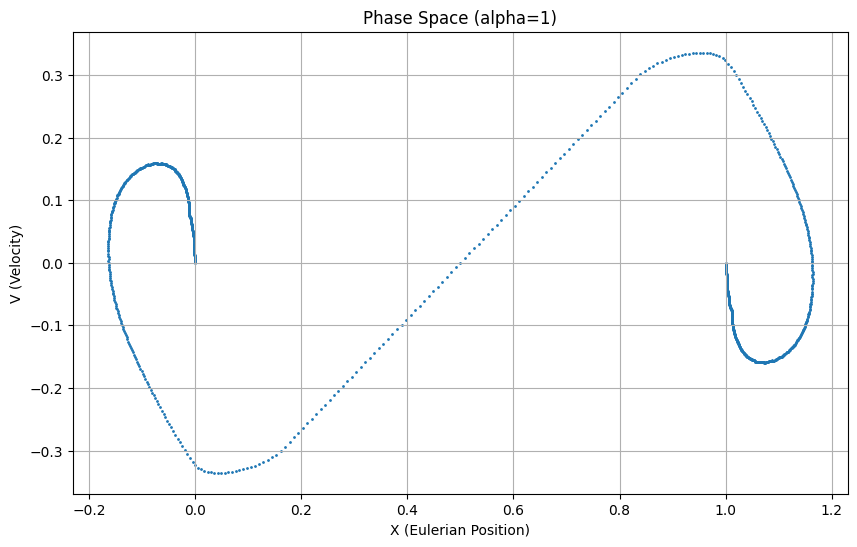

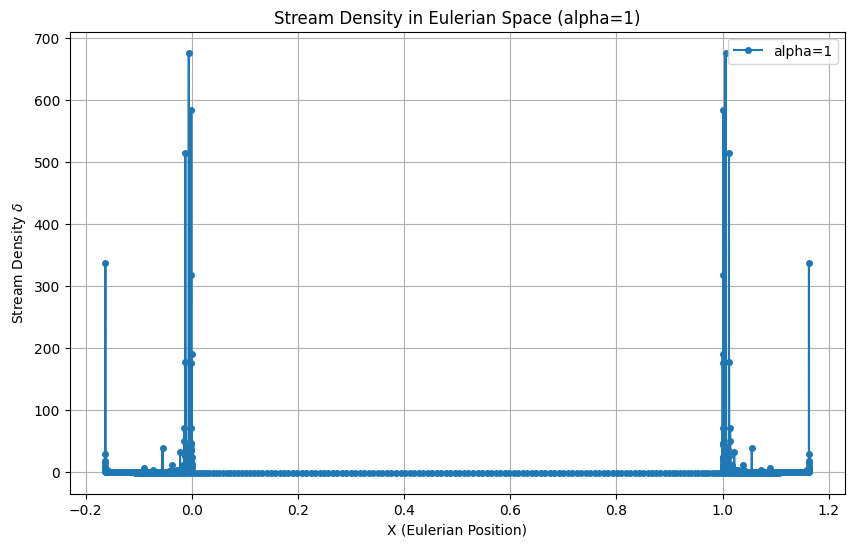

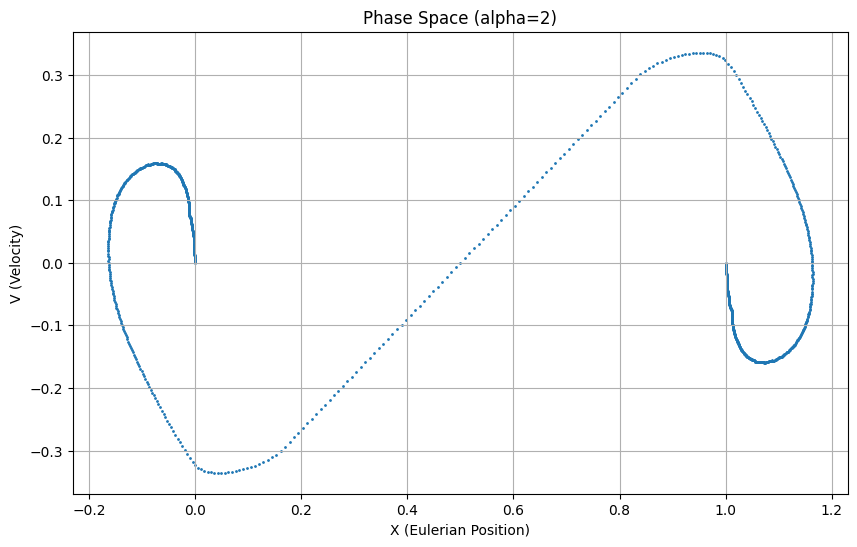

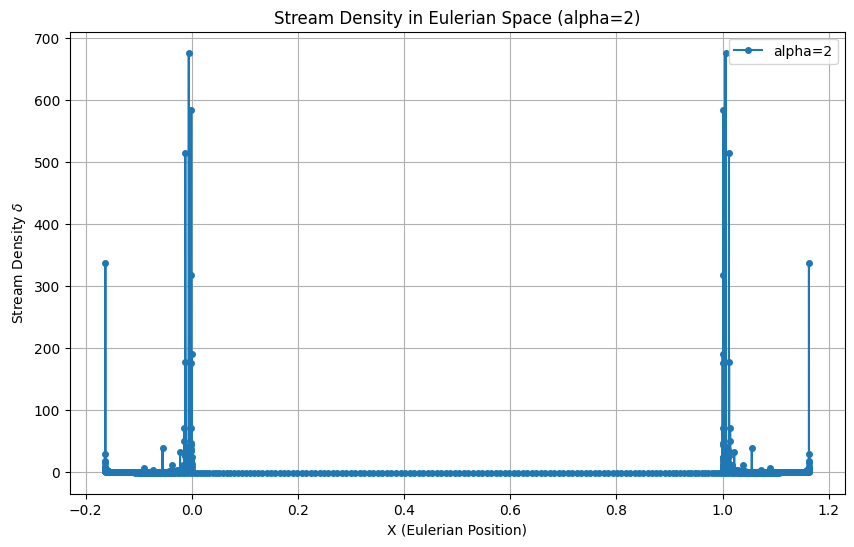

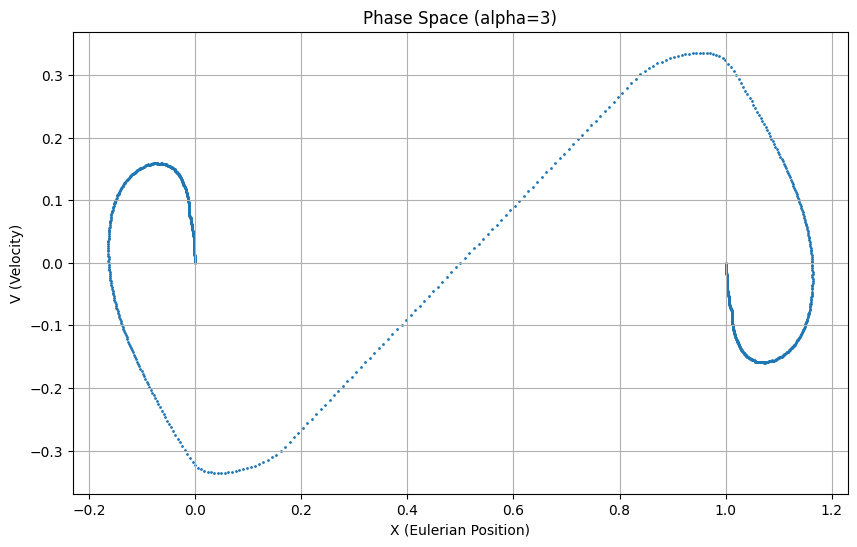

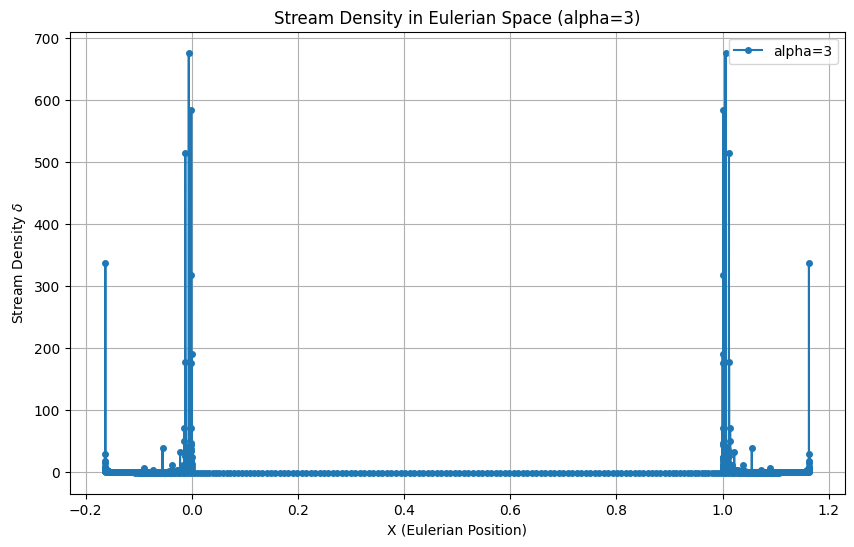

In [110]:
# Parameters
N = 1000  # Number of particles
q = np.linspace(0, 1, N, endpoint=False)  # Lagrangian coordinates
a_start = 0.1  # Initial scale factor
a_end = 1.0  # Final scale factor
num_steps = 128  # Number of time steps

# Function to generate a Gaussian random field with a power-law power spectrum
def generate_gaussian_random_field(N, alpha):
    k = fftfreq(N) * N
    k[0] = 1  # Avoid division by zero at k=0
    amplitude = np.abs(k)**(-alpha / 2.0)
    phase = np.random.rand(N) * 2 * np.pi
    field_k = amplitude * np.exp(1j * phase)
    field = np.real(ifft(field_k))
    field -= np.mean(field)  # Ensure zero mean
    return field

# Function to calculate the Jacobian and stream density
def calc_jacobian_and_stream_density(X, q):
    q_sorted_indices = np.argsort(q)
    X_sorted = X[q_sorted_indices]
    q_sorted = q[q_sorted_indices]
    
    J = np.abs(np.diff(X_sorted) / np.diff(q_sorted))
    delta = 1 / J - 1
    
    X_mid = 0.5 * (X_sorted[:-1] + X_sorted[1:])
    delta_mid = delta
    
    return X_mid, delta_mid

# Power-law indices to compare
alphas = [1, 2, 3]

for alpha in alphas:
    # Generate initial displacement field
    Psi = generate_gaussian_random_field(N, alpha)
    dPsi_dq = np.gradient(Psi, q)
    
    # Zel'dovich approximation to set initial conditions
    X_init = q - a_start * dPsi_dq
    V_init = -dPsi_dq * np.sqrt(1 / a_start)
    
    # Run the simulation
    X_final, V_final = run_simulation(num_steps, zel_consistent_step, a_end)
    
    # Plot phase space
    plt.figure(figsize=(10, 6))
    plt.scatter(X_final, V_final, s=1)
    plt.title(f'Phase Space (alpha={alpha})')
    plt.xlabel('X (Eulerian Position)')
    plt.ylabel('V (Velocity)')
    plt.grid(True)
    plt.show()
    
    # Calculate and plot stream density
    X_mid, delta_mid = calc_jacobian_and_stream_density(X_final, q)
    
    plt.figure(figsize=(10, 6))
    plt.plot(X_mid, delta_mid, marker='o', linestyle='-', markersize=4, label=f'alpha={alpha}')
    plt.xlabel('X (Eulerian Position)')
    plt.ylabel('Stream Density $\\delta$')
    plt.title(f'Stream Density in Eulerian Space (alpha={alpha})')
    plt.grid(True)
    plt.legend()
    plt.show()
